### 数据预处理

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. 读取数据 - 真实数据往往有隐藏陷阱
# 注意：实际数据常含隐藏空格/特殊字符，需strip处理
df = pd.read_csv('./nigerian-songs.csv', encoding='utf-8')
print(f"原始数据形状: {df.shape}")



原始数据形状: (530, 16)


In [4]:
# 2. 缺失值检测 - 第一次实战时被非NaN缺失值坑过！
df.isnull().sum()


name                0
album               0
artist              0
artist_top_genre    0
release_date        0
length              0
popularity          0
danceability        0
acousticness        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
time_signature      0
dtype: int64

In [5]:
# 发现'artist_top_genre'列存在"Missing"标记的伪缺失值
print(f"\n流派列唯一值: {df['artist_top_genre'].unique()}")


流派列唯一值: ['alternative r&b' 'afropop' 'indie r&b' 'nigerian pop' 'afro r&b'
 'afro dancehall' 'Missing' 'azonto' 'soft rock' 'hiplife' 'erotica'
 'nigerian hip hop' 'highlife' 'azontobeats' 'south african house'
 'bongo flava' 'afroswing' 'gqom' 'christian afrobeat']


In [6]:
# 3. 处理流派缺失值 - 采用分层填充策略
# 经验：直接填"unknown"会损失信息，按艺人填充更合理
genre_imputer = df.groupby('artist')['artist_top_genre'].transform(
    lambda x: x.mode()[0] if not x.mode().empty else 'unknown'
)
df['artist_top_genre'] = np.where(
    df['artist_top_genre'] == 'Missing', 
    genre_imputer, 
    df['artist_top_genre']
)



In [7]:
# 4. 特征工程 - 课程项目中学到的实用技巧
# 将毫秒转换为分钟更符合业务认知
df['duration_min'] = df['length'] / 60000  

# 从日期中提取年代特征
df['release_year'] = pd.to_datetime(
    df['release_date'], errors='coerce'
).dt.year.fillna(0).astype(int)



In [8]:
# 5. 选择聚类特征 - 聚焦音频核心属性
audio_features = [
    'danceability', 'energy', 'loudness', 
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'tempo', 'duration_min'
]



In [9]:
# 6. 构建预处理管道 
# 注意：数值特征需标准化，分类特征后续可做独热编码（聚类暂不需）
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # 稳健填充
            ('scaler', StandardScaler())                    # 标准化解决量纲问题
        ]), audio_features)
    ],
    remainder='drop'  # 丢弃非特征列
)



In [10]:
# 7. 执行预处理 - 终于理解fit_transform和transform的区别了
X_preprocessed = preprocessor.fit_transform(df)
print(f"\n预处理后数据形状: {X_preprocessed.shape}")

# 8. 备份处理结果 - 项目中的血泪教训：一定要保存中间结果！
preprocessed_df = pd.DataFrame(
    X_preprocessed, 
    columns=audio_features
)
preprocessed_df.to_csv('预处理后音乐数据.csv', index=False)

print("\n=== 预处理验证 ===")
print("均值:", np.round(preprocessed_df.mean(), 2))
print("方差:", np.round(preprocessed_df.std(), 2))


预处理后数据形状: (530, 9)

=== 预处理验证 ===
均值: danceability        0.0
energy              0.0
loudness            0.0
speechiness        -0.0
acousticness        0.0
instrumentalness    0.0
liveness            0.0
tempo               0.0
duration_min       -0.0
dtype: float64
方差: danceability        1.0
energy              1.0
loudness            1.0
speechiness         1.0
acousticness        1.0
instrumentalness    1.0
liveness            1.0
tempo               1.0
duration_min        1.0
dtype: float64


### 建模分析

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 加载预处理后的数据 
preprocessed_df = pd.read_csv('预处理后音乐数据.csv')
print("预处理数据加载成功! 特征:", list(preprocessed_df.columns))

# 2. 确定最佳K值 
# 尝试K范围：2到10 (音乐风格通常不会超过10大类)
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("\n=== 寻找最佳K值 ===")
for k in k_range:
    # 2.1 训练K-Means模型
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # n_init消除警告
    kmeans.fit(preprocessed_df)
    
    # 2.2 记录肘部法则指标
    inertias.append(kmeans.inertia_)  # 簇内平方和
    
    # 2.3 计算轮廓系数 (耗时操作，小提示：样本大时可抽样)
    if k > 1:  # 轮廓系数要求至少2个簇
        score = silhouette_score(preprocessed_df, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"K={k}: 轮廓系数={score:.4f}")
    else:
        silhouette_scores.append(None)



预处理数据加载成功! 特征: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_min']

=== 寻找最佳K值 ===
K=2: 轮廓系数=0.1644
K=3: 轮廓系数=0.2091
K=4: 轮廓系数=0.1939
K=5: 轮廓系数=0.1849
K=6: 轮廓系数=0.1771
K=7: 轮廓系数=0.1397
K=8: 轮廓系数=0.1364
K=9: 轮廓系数=0.1464
K=10: 轮廓系数=0.1365


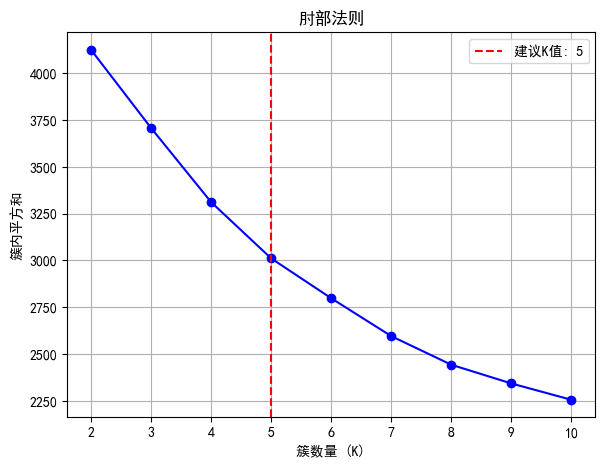

In [12]:
# 3. 可视化评估指标 
plt.figure(figsize=(15, 5))

# 3.1 肘部法则图
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('簇数量 (K)')
plt.ylabel('簇内平方和')
plt.title('肘部法则')
plt.grid(True)

# 标出可能的肘点 (用转折最明显的位置)
elbow_point = np.argmin(np.diff(inertias, 2)) + 2  # 二阶导数最小值
plt.axvline(x=elbow_point, color='r', linestyle='--', 
            label=f'建议K值: {elbow_point}')
plt.legend()



In [24]:

# 4. 用最佳K值建立最终模型 - 选择轮廓系数推荐的K值
final_k = 3 # 也可选elbow_point，这里优先轮廓系数
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(preprocessed_df)




=== 最终模型评估 ===
轮廓系数: 0.2091

簇分布:
0    356
1      8
2    166
Name: count, dtype: int64

簇中心特征 (近似原始值):
   danceability  energy  loudness  speechiness  acousticness  \
0          0.76    0.83     -3.91         0.11          0.21   
1          0.73    0.69     -6.17         0.11          0.35   
2          0.69    0.62     -7.13         0.17          0.37   

   instrumentalness  liveness   tempo  duration_min  
0              0.01      0.13  119.09          3.77  
1              0.68      0.14  108.53          3.18  
2              0.01      0.19  111.28          3.58  


E:\python\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


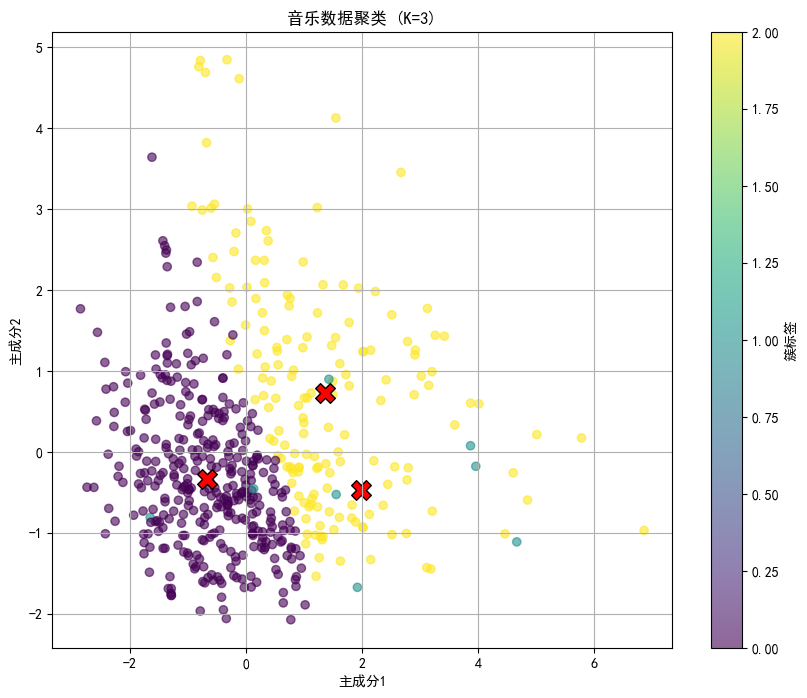

In [25]:
# 5. 评估最终模型 
print("\n=== 最终模型评估 ===")
print(f"轮廓系数: {silhouette_score(preprocessed_df, cluster_labels):.4f}")

# 5.1 分析簇大小分布 - 警惕不均衡问题
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("\n簇分布:")
print(cluster_counts)

# 5.2 分析簇中心特征 - 理解每个簇的音乐特性
centroids = pd.DataFrame(
    final_kmeans.cluster_centers_,
    columns=preprocessed_df.columns
)

# 反向标准化还原原始量纲 (更易解释)
# 回忆：预处理时做了标准化，需要还原特征的真实范围
# 注意：这是近似还原，精确还原需保存scaler对象
original_df = pd.read_csv('./nigerian-songs.csv')
approx_centroids = centroids.copy()
for col in approx_centroids.columns:
    if col == 'duration_min':  # 特殊处理工程特征
        approx_centroids[col] = approx_centroids[col] * np.std(original_df['length']/60000) + np.mean(original_df['length']/60000)
    elif col in original_df.columns:
        approx_centroids[col] = approx_centroids[col] * np.std(original_df[col]) + np.mean(original_df[col])

print("\n簇中心特征 (近似原始值):")
print(approx_centroids.round(2))

# 6. 可视化聚类结果 - 用PCA降到2维
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(preprocessed_df)

plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.6
)
plt.xlabel('主成分1')
plt.ylabel('主成分2')
plt.title(f'音乐数据聚类 (K={final_k})')
plt.colorbar(label='簇标签')

# 标记簇中心位置
centers_reduced = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(
    centers_reduced[:, 0], centers_reduced[:, 1],
    marker='X', s=200, c='red', edgecolor='black'
)

plt.grid(True)
plt.show()




聚类结果已保存，包含原始特征和簇标签！

流派与聚类分布:
Cluster                0  1   2
artist_top_genre               
Missing               31  0  22
afro dancehall       241  4  83
afro r&b               1  0   2
afropop               60  1  29
afroswing              1  0   0
alternative r&b        1  2   4
azonto                 0  0   1
azontobeats            5  0   3
bongo flava            1  0   0
christian afrobeat     1  0   0
erotica                1  0   0
gqom                   1  0   0
highlife               1  0   0
hiplife                1  0   0
indie r&b              0  0   4
nigerian hip hop       3  0   0
nigerian pop           6  1  17
soft rock              0  0   1
south african house    1  0   0


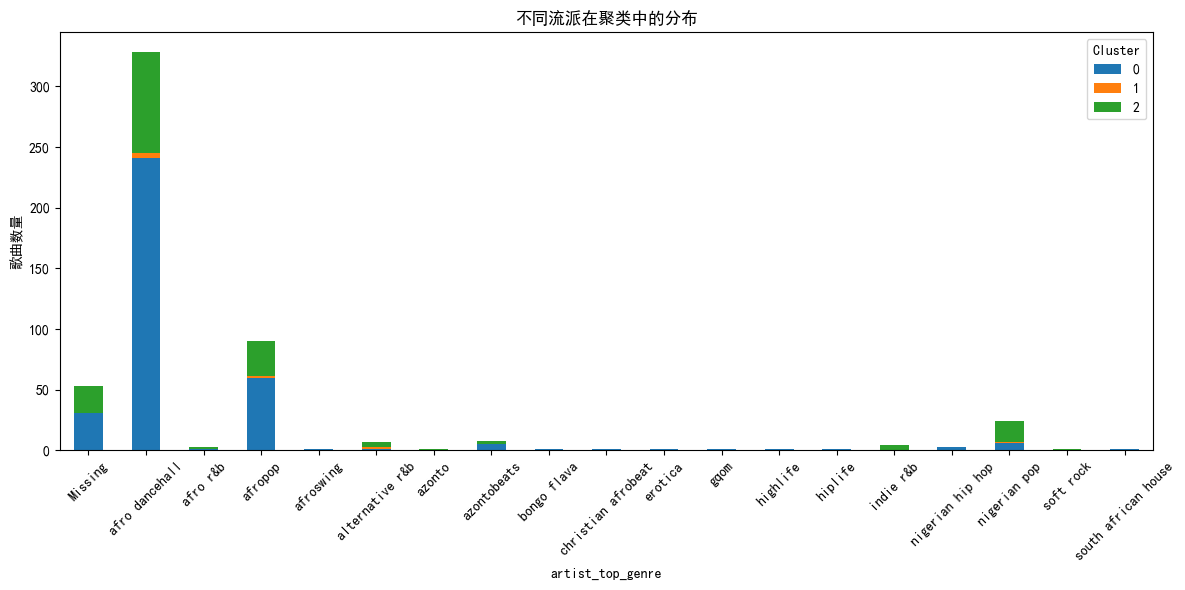

In [27]:
# 7. 业务解读准备 - 把聚类结果关联原始数据
result_df = pd.read_csv('./nigerian-songs.csv')
result_df['Cluster'] = cluster_labels

# 保存完整结果用于深入分析
result_df.to_csv('聚类结果.csv', index=False)
print("聚类结果已保存，包含原始特征和簇标签！")

# 8. 高级分析示例 - 探索流派与聚类的关系
if 'artist_top_genre' in result_df.columns:
    genre_cluster = pd.crosstab(
        result_df['artist_top_genre'], result_df['Cluster']
    )
    print("\n流派与聚类分布:")
    print(genre_cluster)
    
    # 可视化流派分布
    genre_cluster.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('不同流派在聚类中的分布')
    plt.ylabel('歌曲数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()